In [1]:
seed = 42
import numpy as np
np.random.seed(seed)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(seed)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data loading
The Penn Treebank datafiles are given in the urls below, where we have three different datasets: train, validation and test. Data was downloaded from [train](https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt), [validation](https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt) and [test](https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt). 

In [2]:
def load_corpus(path): 
    corpus = []
    with open(path, 'r') as infile: 
        for line in infile: 
            line = line[:-1].split()
            corpus.append(line)
    return corpus

In [3]:
# Make corpus
def corpus_counts(path, verbose=False): 
    # Open training file 
    corpus = load_corpus(path=path)

    # Count occurrences
    unique, counts = np.unique(np.array([item for sublist in corpus for item in sublist]), return_counts=True)
    corpus_counts = dict(zip(unique, counts))
    
    if verbose: 
        for v, k in sorted(zip(counts, unique), reverse=True): 
            print('Key is "{0}" with count {1}'.format(k, v))
    
    # Build vocabulary
    vocab_size = len(corpus_counts)
    word_to_idx = {word: i+1 for i, word in enumerate(corpus_counts.keys())}
    word_to_idx['padding'] = 0
    
    return corpus, corpus_counts, word_to_idx

## Data loader

In [4]:
# Function to make context pairs
def make_context_pairs(data, word_to_idx, window_size=2): 
    # Run through each sample
    word_data = []
    for line in data: 
        # Add padding corresponding to the size of the window on either side
        padding = ['padding']*window_size
        line = padding+line+padding
        
        # Make contexts
        for i in range(window_size, len(line) - window_size):
            context, c = [], -window_size
            while c <= window_size:
                if c != 0: 
                    context.append(line[i+c])
                c += 1
            word_data.append((context, line[i]))
    
    return word_data

## Load data

In [5]:
# Make corpus
train, train_counts, word_to_idx = corpus_counts(path='data/ptb.train.txt', verbose=False)

In [6]:
# Set window size 
ws = 2

In [7]:
# Load training data
#words, word_to_idx = data_loader(path='data/ptb.train.txt', window_size=2)
train_words = make_context_pairs(data=train, word_to_idx=word_to_idx, window_size=ws)

In [8]:
# Check word contexts
word_sum = len(train_words)
print(word_sum)
for context, word in train_words[:10]: 
    #s, t = context_pair
    #print(s, t)
    print(context, word)

887521
['padding', 'padding', 'banknote', 'berlitz'] aer
['padding', 'aer', 'berlitz', 'calloway'] banknote
['aer', 'banknote', 'calloway', 'centrust'] berlitz
['banknote', 'berlitz', 'centrust', 'cluett'] calloway
['berlitz', 'calloway', 'cluett', 'fromstein'] centrust
['calloway', 'centrust', 'fromstein', 'gitano'] cluett
['centrust', 'cluett', 'gitano', 'guterman'] fromstein
['cluett', 'fromstein', 'guterman', 'hydro-quebec'] gitano
['fromstein', 'gitano', 'hydro-quebec', 'ipo'] guterman
['gitano', 'guterman', 'ipo', 'kia'] hydro-quebec


In [9]:
# Load validation data
valid = load_corpus(path='data/ptb.valid.txt')
valid_words = make_context_pairs(data=valid, word_to_idx=word_to_idx, window_size=ws)

After data has been loaded it is good to check what is looks like. 

In [10]:
print('Number of training samples:\t', len(train_words))
print('Number of validation samples:\t', len(valid_words))

Number of training samples:	 887521
Number of validation samples:	 70390


# CBOW class

In [11]:
class cbow(nn.Module):

    def __init__(self, vocab_size, embedding_dim, window_size):
        super(cbow, self).__init__()
        # num_embeddings is the number of words in your train, val and test set
        # embedding_dim is the dimension of the word vectors you are using
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, 
                                      padding_idx=0)
        self.linear1 = nn.Linear(in_features=window_size * embedding_dim, out_features=128, bias=True)
        self.linear2 = nn.Linear(in_features=128, out_features=vocab_size, bias=False)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)#.view((1, -1))
        #print(embeds.shape, embeds.view((-1, 4)).shape)
        out = F.relu(self.linear1(embeds.view((-1, 4))))
        out = self.linear2(out)
        probs = F.softmax(out, dim=1)
        return probs

# Model training

In [12]:
# Set loss, model and optimizer
loss_function = nn.CrossEntropyLoss()
model = cbow(vocab_size=len(train_counts), embedding_dim=1, window_size=ws*2)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
# Look at loaded model
model

cbow(
  (embeddings): Embedding(9999, 1, padding_idx=0)
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=9999, bias=False)
)

In [14]:
# Get batch slice
def get_batch(batch_size, i):
    start_idx = i*batch_size
    end_idx = (i+1)*batch_size
    return start_idx, end_idx

def batch_to_context(batch, word_to_idx): 
    x_batch, y_batch =  [], []
    
    # Run through samples
    for context, target in batch: 
        x = [word_to_idx[w] for w in context]
        y = word_to_idx[target]
        
        # Append idx words to batch
        x_batch.append(x)
        y_batch.append(y)
    
    # Make tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long)
    y_batch = torch.tensor(y_batch, dtype=torch.long)
    return x_batch, y_batch

In [15]:
losses = []
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

max_epochs = 100
batch_size = 100
train_sample = train_words[:10000]
valid_sample = valid_words[:1000]

#n_train_batches = len(train_words) // batch_size
n_train_batches = len(train_sample) // batch_size
#n_valid_batches = len(valid_words) // batch_size
n_valid_batches = len(valid_sample) // batch_size
print(n_train_batches, n_valid_batches)

# Run through epochs
for epoch in range(max_epochs):
    print('# Epoch {0}/{1}'.format(epoch+1, max_epochs))
    
    ### Train ###
    # Shuffle training data
    #shuffled = train_words.copy()
    shuffled = train_sample.copy()
    np.random.RandomState(seed=seed).shuffle(shuffled)
    
    # Iterate mini batches
    current_loss = 0
    model.train()
    for i in range(n_train_batches): 
        start_idx, end_idx = get_batch(batch_size=batch_size, i=i)
        batch = shuffled[start_idx:end_idx]
        
        # Step 1. Turn words to indices and wrap in tensors
        x_batch, y_batch = batch_to_context(batch=batch, word_to_idx=word_to_idx)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting probabilities over next words
        probs = model(x_batch)

        # Step 4. Compute your loss function.
        loss = loss_function(probs, y_batch)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        current_loss += loss.item()  
    losses.append(current_loss)

    
    ### Evaluate training ###
    model.eval()
    train_preds, train_targs = [], []
    for i in range(n_train_batches):
        # Make batch
        start_idx, end_idx = get_batch(batch_size=batch_size, i=i)
        batch = shuffled[start_idx:end_idx]
        x_batch, y_batch = batch_to_context(batch=batch, word_to_idx=word_to_idx)
        
        # Get predictions
        output = model(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_batch)
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation ###
    val_preds, val_targs = [], []
    for i in range(n_valid_batches):
        start_idx, end_idx = get_batch(batch_size=batch_size, i=i)
        batch = valid_words[start_idx:end_idx]
        x_batch, y_batch = batch_to_context(batch=batch, word_to_idx=word_to_idx)
        
        output = model(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(y_batch)

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f\n" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

100 10
# Epoch 1/100
Epoch  1 : Train Loss 915.467948 , Train acc 0.084800, Valid acc 0.062000

# Epoch 2/100
# Epoch 3/100
# Epoch 4/100
# Epoch 5/100
# Epoch 6/100
# Epoch 7/100
# Epoch 8/100
# Epoch 9/100
# Epoch 10/100
# Epoch 11/100
Epoch 11 : Train Loss 909.889378 , Train acc 0.111400, Valid acc 0.068000

# Epoch 12/100
# Epoch 13/100
# Epoch 14/100
# Epoch 15/100
# Epoch 16/100
# Epoch 17/100
# Epoch 18/100
# Epoch 19/100
# Epoch 20/100
# Epoch 21/100
Epoch 21 : Train Loss 909.470689 , Train acc 0.116500, Valid acc 0.072000

# Epoch 22/100
# Epoch 23/100
# Epoch 24/100
# Epoch 25/100
# Epoch 26/100
# Epoch 27/100
# Epoch 28/100
# Epoch 29/100
# Epoch 30/100
# Epoch 31/100
Epoch 31 : Train Loss 909.270439 , Train acc 0.119400, Valid acc 0.069000

# Epoch 32/100
# Epoch 33/100
# Epoch 34/100
# Epoch 35/100
# Epoch 36/100
# Epoch 37/100
# Epoch 38/100
# Epoch 39/100
# Epoch 40/100
# Epoch 41/100
Epoch 41 : Train Loss 908.999794 , Train acc 0.120900, Valid acc 0.072000

# Epoch 42/1

In [16]:
print(losses)  # The loss does not decrease that much...

[915.4679479598999, 912.7532720565796, 912.0352764129639, 911.3845415115356, 910.8033285140991, 910.5577421188354, 910.3872222900391, 910.1096391677856, 910.1094408035278, 910.2263984680176, 909.8893775939941, 909.9443321228027, 909.8281593322754, 909.7513284683228, 909.696795463562, 909.7926692962646, 909.6222457885742, 909.5670309066772, 909.5550012588501, 909.4972829818726, 909.4706888198853, 909.4804677963257, 909.4514970779419, 909.3448333740234, 909.3507413864136, 909.3246726989746, 909.2935771942139, 909.2784843444824, 909.352388381958, 909.2795963287354, 909.2704391479492, 909.1460161209106, 909.0623331069946, 909.0295972824097, 909.0131397247314, 908.9833288192749, 908.9727935791016, 908.9798183441162, 908.9626922607422, 909.0728406906128, 908.9997940063477, 908.9591073989868, 908.9660768508911, 908.9627199172974, 908.9525566101074, 908.9544820785522, 908.9513959884644, 908.9519052505493, 909.065770149231, 909.06471824646, 909.1997337341309, 909.128026008606, 909.1141929626465

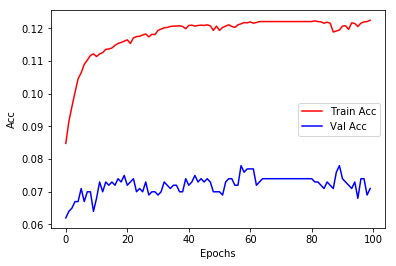

In [17]:
# Plot training and validation performances
epoch = np.arange(max_epochs)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

In [18]:
### Evaluate test set
#x_batch = Variable(torch.from_numpy(x_test))
#output = net(x_batch)
#preds = torch.max(output, 1)[1]
#print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

# Notes 